In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import sys
from scipy import constants

### Preprocessing

In [17]:

Eqf = lambda l, I: 10 * constants.pi * I * l * constants.nano / (constants.h * constants.c * constants.Avogadro * constants.micro) # [umol/m2s = muE]

print("Q from W/m2 for 555nm and 200W/m2: ", Eqf(555, 200))
print("Q from W/m2 for 555nm and 800W/m2: ", Eqf(555, 800))
print("Q from W/m2 for 555nm and 1000W/m2: ", Eqf(555, 1000))
print("Q from W/m2 for 555nm and 1200W/m2: ", Eqf(555, 1200))
print("Q from W/m2 for 555nm and 1400W/m2: ", Eqf(555, 1400))

Q from W/m2 for 555nm and 200W/m2:  29150.44686659997
Q from W/m2 for 555nm and 800W/m2:  116601.78746639988
Q from W/m2 for 555nm and 1000W/m2:  145752.23433299985
Q from W/m2 for 555nm and 1200W/m2:  174902.68119959984
Q from W/m2 for 555nm and 1400W/m2:  204053.1280661998


In [18]:
filename = "output_*.csv"
files = glob.glob(filename)
# take newest file
files.sort(key=os.path.getmtime)
filename = files[-2]
print("Reading file: ", filename)

Reading file:  output_1724511607018.csv


In [19]:
data = pd.read_csv(filename, skiprows=6)
data = data.dropna()
# strip column names
data.columns = data.columns.str.strip()
# columns time is a string in format %Y.%m.%d-%H:%M:%S
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y.%m.%d-%H:%M:%S')
# make the time the index
data.set_index('Timestamp', inplace=True)
# make time local
data.index = data.index.tz_localize('UTC')
# remove unnamed columns
data = data.loc[:, ~data.columns.str.contains('^idx')]
# extract start timestamp from first line in file
data.interpolate(method='time', inplace=True)

In [20]:
times = data["Systime"].to_numpy()
times = times - times[0]
# compute consecutive differences
time_diffs = np.diff(times)
# compute statistics
print("Time since start: ", times[-1] / 60, " minutes")
print("Mean time between samples: ", time_diffs.mean())
print("Std time between samples: ", time_diffs.std())

Time since start:  281.64739865461985  minutes
Mean time between samples:  2.9338270693189568
Std time between samples:  9.45126615999322


In [21]:
# restrict data to 6:00 to 22:00
data = data.between_time('06:00', '22:00')

In [22]:
# print columns and their types and starting values
print(data.dtypes)
print(data.head())


Systime             float64
plant [#]             int64
light [Q]           float64
Flux [cm3/day]      float64
An [umol/m2/s]      float64
Vc [umol/m2/s]      float64
Vj [umol/m2/s]      float64
gco2 [umol/m2/s]    float64
cics [-]            float64
fw [-]              float64
dtype: object
                                Systime  plant [#]  light [Q]  Flux [cm3/day]  \
Timestamp                                                                       
2019-06-01 13:00:00+00:00  1.724512e+09          0      0.000        0.000000   
2019-06-01 13:00:00+00:00  1.724512e+09          0  16049.078        0.000002   
2019-06-01 13:00:00+00:00  1.724512e+09          1  43073.300        0.000002   
2019-06-01 13:00:00+00:00  1.724512e+09          2  39157.547        0.000002   
2019-06-01 13:00:00+00:00  1.724512e+09          3  39157.547        0.000002   

                           An [umol/m2/s]  Vc [umol/m2/s]  Vj [umol/m2/s]  \
Timestamp                                                    

### General Plots

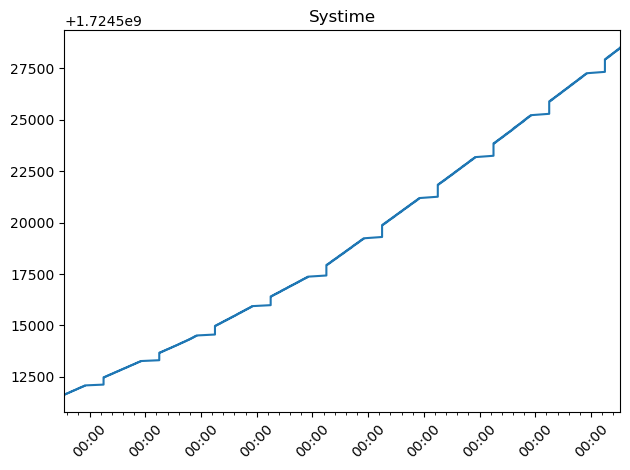

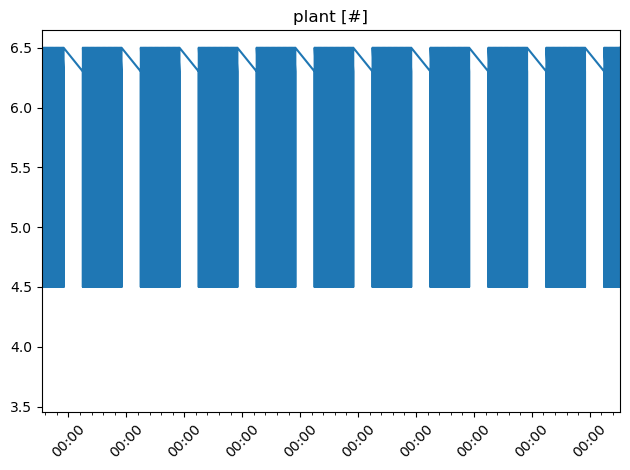

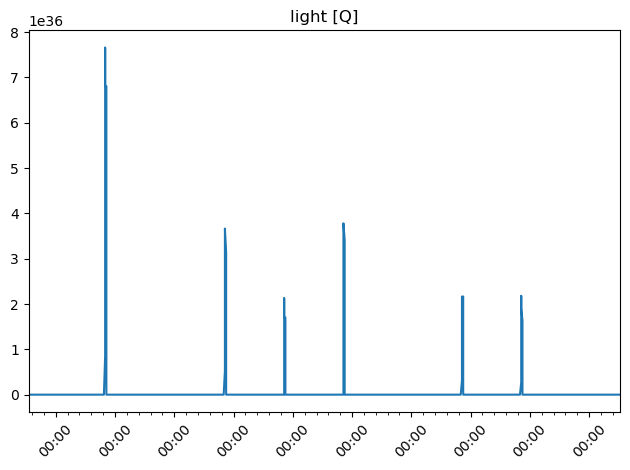

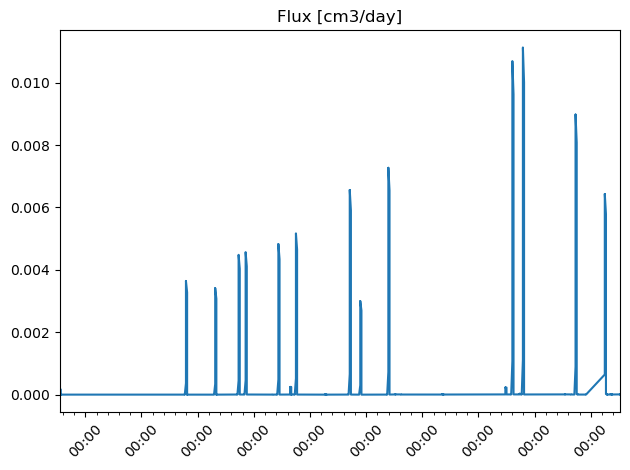

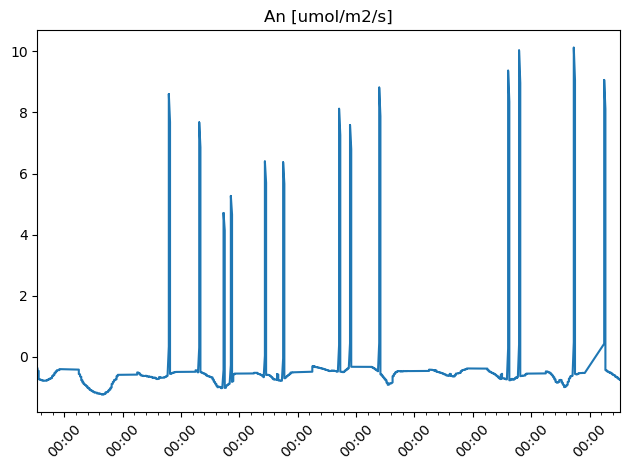

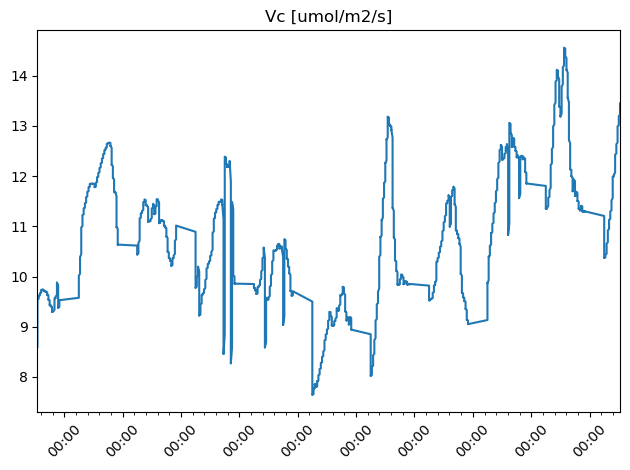

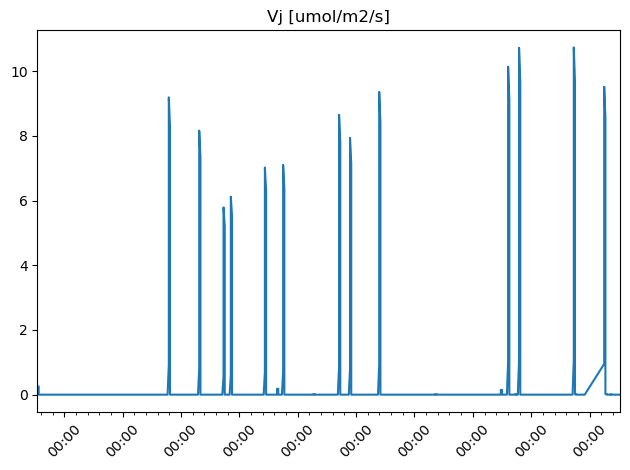

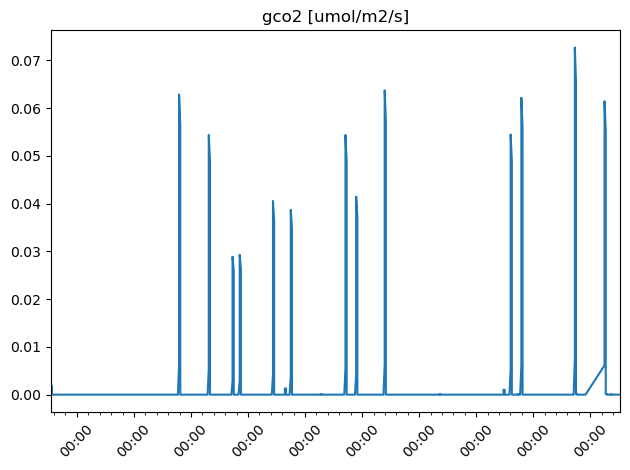

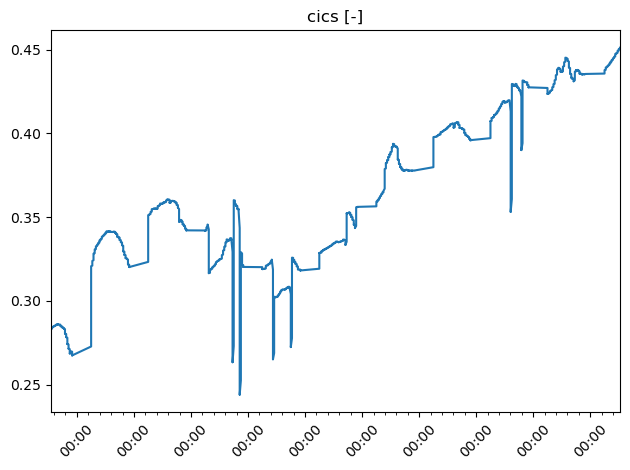

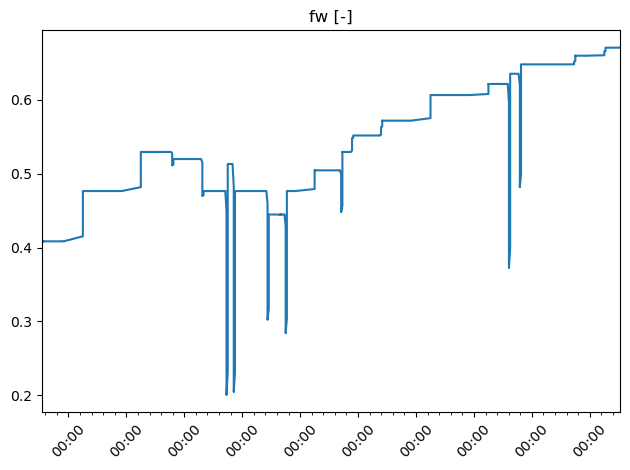

In [23]:
import matplotlib.dates as mdates
for c in data.columns :
  # plot all data as a start
  fig, ax = plt.subplots()
  mva = data[c].rolling(window=10).mean()
  ax.plot(mva)
  # xticks with time and date if data changed
  plt.xticks(rotation=45)
  plt.tight_layout()
  # set xlim to the data
  ax.set_xlim(data.index[0], data.index[-1])
  # show hour and minutes on x-axis
  ax.xaxis.set_major_locator(plt.MaxNLocator(10))
  ax.xaxis.set_minor_locator(plt.MaxNLocator(60))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  # set ylim to the data
  day = -1
  ax.set_title(c)
  plt.tight_layout()
  plt.show()

In [24]:
# add the selhausen data for overlay
filename = "SE_EC_001.1711883710395.csv"
with open ("SE_EC_001.1711883710395.csv", "r") as f :
  # get line 93
  for i in range(92) :
    f.readline()
  # get the column data
  line = f.readline()[1:]
  line = [c.strip() for c in line.split(",")]
  columns = line
# endwith
seldata = pd.read_csv("SE_EC_001.1711883710395.csv", skiprows = 93, names = columns)
for col in seldata.columns:
  if "QualityFlag" in col:
    seldata[col] = seldata[col].str.split("_", expand=True)[1]
    # convert the values to numeric
    seldata[col] = pd.to_numeric(seldata[col], errors='coerce')
  # endif
# endfor
# exchange "noData" with NaN
seldata = seldata.replace("noData", np.nan)
# convert the time to datetime
seldata["Time"] = pd.to_datetime(seldata["Time"], format="%Y-%m-%dT%H:%M:%S%z")
seldata = seldata.set_index("Time")
quality_flags = data.filter(like="QualityFlag")
seldata = seldata.drop(columns = quality_flags.columns)
seldata = seldata.drop(columns="feature")
seldata = seldata.apply(pd.to_numeric, errors='coerce')
seldata.sort_index(inplace=True)
seldata.index = pd.to_datetime(seldata.index, format="%Y-%m-%dT%H:%M:%S%z", utc=True)
quality_flags.index = seldata.index
seldata = seldata.asfreq("10T")
quality_flags = quality_flags.asfreq("10T")
seldata.interpolate(inplace = True, method = "time")

/tmp/ipykernel_19554/1664693118.py:12: DtypeWarning: Columns (26,32,38,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80) have mixed types. Specify dtype option on import or set low_memory=False.
  seldata = pd.read_csv("SE_EC_001.1711883710395.csv", skiprows = 93, names = columns)
/tmp/ipykernel_19554/1664693118.py:23: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  seldata["Time"] = pd.to_datetime(seldata["Time"], format="%Y-%m-%dT%H:%M:%S%z")
/tmp/ipykernel_19554/1664693118.py:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  seldata = seldata.asfreq("10T")
/tmp/ipykernel_19554/1664693118.py:33: FutureWarning: 'T' is deprecated and will be removed in a future vers

In [25]:
# filter selhausen data such that indices are the same
seldata = seldata.loc[data.index[0]:data.index[-1]]
# make sure that indices are the same
seldata = seldata.reindex(data.index, method='nearest')

In [26]:
def column_like(data, like):
  lower = like.lower()
  for c in data.columns:
    if lower in c.lower():
      return c
  return None
# enddef

airtemp_c = column_like(seldata, "AirTemp")
print(airtemp_c)


AirTemperature_2m_Avg10min_Sensor1 [°C]


/tmp/ipykernel_19554/2760282179.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_19554/2760282179.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


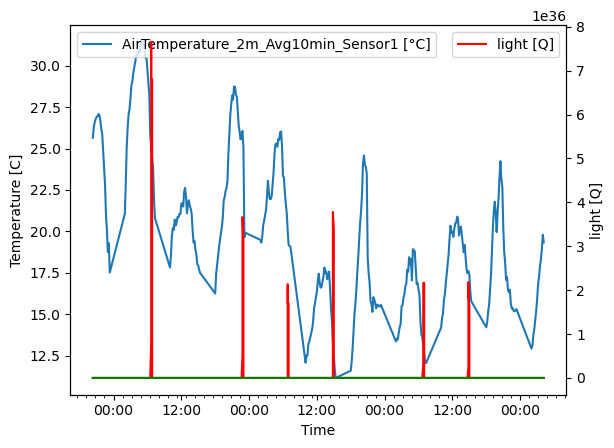

In [27]:
# plot temperature(seldata), PAR(seldata), and Q(data)
fig, ax = plt.subplots()
ax.plot(seldata.index, seldata[airtemp_c], label=airtemp_c)
ax.set_ylabel("Temperature [C]")
ax.set_xlabel("Time")
ax.legend(loc="upper left")
ax2 = ax.twinx()
mval = data[column_like(data, "light")].rolling(window=10).mean()
ax2.plot(mval, label=column_like(data, "light"), color="red")
ax2.set_ylabel(column_like(data, "light"))
ax2.legend(loc="upper right")
c = column_like(seldata, "RadiationPhotosyntheticActive_2m_Avg10min")
ax2.plot(data.index, seldata[c], label=c, color="green")
# 45 degree axis label
# get the axes
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_minor_locator(plt.MaxNLocator(60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.show()

In [28]:
seldata.head()

,AirConcentration_CO2_2m_Avg30min [mmol*m-3],AirConcentration_CO2_2m_Avg30minQualityFlag,AirFlux_CO2_Avg30min_BelowObsHeight [umol*m-2*s-1],AirFlux_CO2_Avg30min_BelowObsHeightQualityFlag,AirFlux_CO2_Avg30min_NetExchange [umol*m-2*s-1],AirFlux_CO2_Avg30min_NetExchangeQualityFlag,AirFlux_CO2_RelErrNoise [%],AirFlux_CO2_RelErrNoiseQualityFlag,AirFlux_CO2_RelErrRandom [%],AirFlux_CO2_RelErrRandomQualityFlag,...,WindDirection_2.52m_Avg10minQualityFlag,WindDirection_38m_Avg30min [°N],WindDirection_38m_Avg30minQualityFlag,WindFrictionVelocity [m*s-1],WindFrictionVelocityQualityFlag,WindSpeed_2m_Avg10min [m*s-1],WindSpeed_2m_Avg10minQualityFlag,WindSpeed_2m_Avg30min [m*s-1],WindSpeed_2m_Avg30minQualityFlag,
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-01 13:00:00+00:00,16.02269,2025.0,-0.0382,2025.0,0.6877,2025.0,0.146019,2025.0,12.655793,2025.0,...,2002.0,10.56305,2025.0,0.091863,2025.0,0.155983,2002.0,1.053786,2025.0,NaN
2019-06-01 13:00:00+00:00,16.02269,2025.0,-0.0382,2025.0,0.6877,2025.0,0.146019,2025.0,12.655793,2025.0,...,2002.0,10.56305,2025.0,0.091863,2025.0,0.155983,2002.0,1.053786,2025.0,NaN
2019-06-01 13:00:00+00:00,16.02269,2025.0,-0.0382,2025.0,0.6877,2025.0,0.146019,2025.0,12.655793,2025.0,...,2002.0,10.56305,2025.0,0.091863,2025.0,0.155983,2002.0,1.053786,2025.0,NaN
2019-06-01 13:00:00+00:00,16.02269,2025.0,-0.0382,2025.0,0.6877,2025.0,0.146019,2025.0,12.655793,2025.0,...,2002.0,10.56305,2025.0,0.091863,2025.0,0.155983,2002.0,1.053786,2025.0,NaN
2019-06-01 13:00:00+00:00,16.02269,2025.0,-0.0382,2025.0,0.6877,2025.0,0.146019,2025.0,12.655793,2025.0,...,2002.0,10.56305,2025.0,0.091863,2025.0,0.155983,2002.0,1.053786,2025.0,NaN


/tmp/ipykernel_19554/1960964892.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


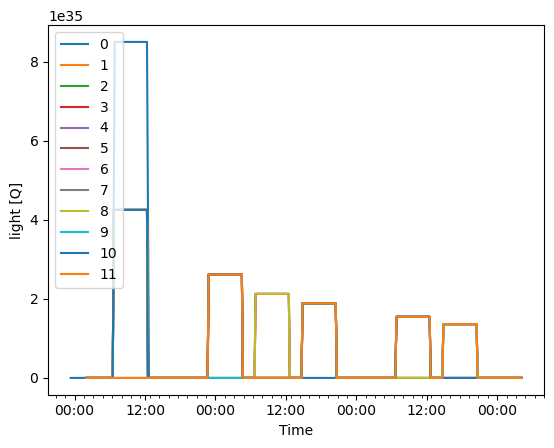

In [29]:
light_c = column_like(data, "light")
plant_c = column_like(data, "plant")
# plot light influx for each plant
fig, ax = plt.subplots()
for p in data[plant_c].unique():
  mask = data[plant_c] == p
  mva = data[light_c][mask].rolling(window=20).mean()
  ax.plot(data.index[mask], mva, label=p)
  #ax.plot(data.index[mask], data[light_c][mask], label=p)
ax.set_ylabel(light_c)
ax.set_xlabel("Time")
# show hours and minutes on x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_minor_locator(plt.MaxNLocator(60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(loc="upper left")
fig.show()

In [30]:
import base64
import json
import numpy as np
import sys
base = {"type":"pms"}
clen = len(json.dumps(base))
arraylen = 1
print("length of base: ", clen)
while clen < 2**16 - 3 :
  base["p"] = base64.b64encode(np.arange(arraylen).tobytes()).decode("utf-8")
  arraylen += 1
  clen = len(json.dumps(base))
#endwhile
print("Maximum message length: ", clen)
print("Array length: ", arraylen)

length of base:  15
Maximum message length:  65540
Array length:  6143
